# Project convex optimization: oligomerization of proteins

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

$X = += t \delta X$

$X = np.max(X, 10^{-10})$

to make sure that concentrations are positive

Daan Van Hauwermeiren, Bram De Jaegher

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-dark')
import pandas as pd

In this project we will study the association of protein complexes through the principle of **entropy maximization**. 

Consider the following three proteins: A, B and C:

![Three monomeric proteins.](Figures/monomers.jpg)

Each of these proteins has sites which it can use to reversible bind to other proteins. Two types of interactions can be distinguished:
- **weak type I interactions**: protein A has one type I donor site, protein C has one type I acceptor site and protein B has both an acceptor and a donor site. In the figures, these sites are indicated as a triangle sticking in (acceptor) or out (donor) the protein.
- **strong type II interaction**: protein A has one type II acceptor site and protein C has one type II donor site. These sites are depicted as two bumps sticking out or pressing in the protein.

These sites allow for dimerisation of the proteins. All possible homo- and hetero-dimers are shown below.

![The proteins can form dimers according to their sites.](Figures/dimers.jpg)

But tri-and tetramers can also be formed:

![One trimer and three tetramers.](Figures/oligomers.jpg)

Let us use one (monomer), two (dimer), three (trimer) and four (tetramer) character long strings to denote all possible conformations. Here we use the convention that the string $P_1P_2P_3P_4$ represents the tetramer
$$
\left (\begin{array}{cc}
P_1 & P_2 \\
P_4 & P_3\end{array} 
\right ) \,.
$$

Note that in our notation, we have
$$
P_1P_2P_3P_4 = P_4P_1P_2P_3 = P_3P_4P_1P_2 = P_2P_3P_4P_1\,,
$$
but
$$
P_1P_2P_3 \neq P_3P_1P_2 \neq P_2P_3P_1\,.
$$

The following code identifies all unique mono-and oligomers.

In [2]:
monomers = set(['A', 'B', 'C'])

dimers = set(['AC', 'CB', 'CA', 'BA', 'BB'])

trimers = set([dm1 + dm2[1] for dm1 in dimers
               for dm2 in dimers if dm1[1:] == dm2[:-1]])

tetramers = set([dm1 + dm2[2] for dm1 in trimers
                 for dm2 in trimers if dm1[1:] == dm2[:-1]
                 if dm2[-1] + dm1[0] in dimers])

# some tetramers are counted multiple times, because our encoding is not unique
# let us remove duplicates

lowest_lexo = lambda polymer : sorted([polymer[i:] + polymer[:i] for i in range(len(polymer))])[0]
tetramers = set(map(lowest_lexo, tetramers))

compounds = monomers | dimers | trimers | tetramers
compounds = list(compounds)
compounds.sort()
monomers =list(monomers)
monomers.sort()

print('There are {} unique compounds'.format(len(compounds)))

There are 19 unique compounds


In [3]:
monomers

['A', 'B', 'C']

In [4]:
compounds

['A',
 'AC',
 'ACA',
 'ACAC',
 'ACB',
 'ACBB',
 'B',
 'BA',
 'BAC',
 'BB',
 'BBA',
 'BBB',
 'BBBB',
 'C',
 'CA',
 'CAC',
 'CB',
 'CBA',
 'CBB']

Oligiomerzation is a process that releases energy. The change of heat in a system is quantified by the enthalpy. Formation of a type I bonds results in a change of enthalphy of $\Delta H$ of -1 Joule / mol (heat is released when two monomers bind), while type II bonds have a change of enthalpy of $\Delta H$ of -2 Joule / mol.

The following piece of code returns the energy the formation enthalpy of a compound.

In [5]:
binding_enthalpy = {'AC' : -2, 'BA' : -1, 'BB' : -1, 'CA' : -1, 'CB' : -1}

def get_enthalpy(compound):
    if len(compound) == 1:
        return 0  # no bonds
    else:
        enthalpy = 0
        for i in range(len(compound) - 1):
            dimer = compound[i:i+2]
            enthalpy += binding_enthalpy[dimer]
        if len(compound)==4:
            enthalpy += binding_enthalpy[compound[-1] + compound[0]]
        return enthalpy

In [6]:
enthalpies_dict = {compound : get_enthalpy(compound) for compound in compounds}

print('Formation enthalpies:')
for compound, enthalpy in enthalpies_dict.items():
    print('{} => {}'.format(compound, enthalpy))
    
enthalpies = [enthalpies_dict[comp] for comp in compounds]  # as list, same order as compounds
enthalpies = np.array(enthalpies).reshape((-1, 1))  # as Numpy array

Formation enthalpies:
CAC => -3
BBBB => -4
A => 0
CBB => -2
CB => -1
BB => -1
AC => -2
B => 0
BBB => -2
C => 0
BA => -1
ACAC => -6
BAC => -3
ACB => -3
BBA => -2
ACA => -3
CBA => -2
ACBB => -5
CA => -1


Since all the association and dissociation reactions are assumed to be reversible, a mixture of the three monomers should give rise to all possible mono- and oligomers (though not necessarily in equal quantities). We will assume that the system will go to an equilibrium where the Gibbs free engery is highest. The Gibbs free energy depends both on the entropy as well as the enthalpy of the system.

Let us denote $x$ as the vector containing the concentrations of the 19 possible species. The entropy of the system is given by

$$
S(\mathbf{x}) = - \sum_{i=1}^{19}x_i \log x_i\,.
$$

The enthalpy of the system is given by

$$
H(\mathbf{x}) = \sum_{i=1}^{19}x_i h_i\,,
$$

with $h_i$ the formation enthalpy of compound $i$.

The Gibbs free energy is then given by

$$
G(\mathbf{x}) = H(\mathbf{x}) - T S(\mathbf{x})
$$

with $T\geq0$ the temperature of the system (in Kelvin). Systems with a constant temperture go to a state with a minimal Gibbs free energy.

Note that:
- By low temperatures, enthalpy dominates. The enthalpy can be raised by the formation of oligomers with multiple low-energy bonds.
- By high temperature, entropy dominates. High entropy can be obtained by having many different species at a low concentration.

The concentration of each species can not be freely chosen, vector $x$ has two types of constraints:
- **equality constraints**: there is a conservation of mass: the total quantity of A, B, C in all the species should remain constant. These form four linear equality contraints.
- **inequality constraints**: since $x$ is a vector with concentrations all elements should be larger than zero: i.e. $x_i \geq 0$. 

The equality constraints are given by the stoichiometric matrix $S$, a $3\times 19$ matrix which quantifies how many of individual molecules $A$, $B$ and $C$ are in a complex and $c$ is the vector of length 3 containing the total of $A$, $B$ and $C$ in the system.

The optimization problem can thus be formulated as follows:

$$
\min_\mathbf{x} G(\mathbf{x}) = H(\mathbf{x}) - T S(\mathbf{x})
$$
$$
\text{subject to }  \mathbf{x} \succeq 0
$$
$$
S\mathbf{x}=\mathbf{c}\,.
$$

In this project you will have to find the equilibrium concentrations by minimizing the Gibbs free energy by a given temperature.

> NOTE: We have chosen **not** to explicitly add the inequality constraints in the optimization problem (i.e. using the logaritmic barrier function). The entropy term will ensure that a minimizer of the Gibbs free energy will always have strictly positive values of $\mathbf{x}$, i.e. concentrations greater than 0. This can easily be seen by noting that $\partial S(\mathbf{x})/\partial x_i|_{0}=-\infty$. To circumvent numerical problems, at the end of every Newton step, we will enforce feasibility by making sure that every component of $\mathbf{x}$ is greater than some small positive tolerance ($10^{-10}$).

** Project assignments**

1. Suppose that an initial mixture contains only the monomers A, B and C with relative fractions of 0.3, 0.4 and 0.3. Give the matrix $S$ and vector $\mathbf{c}$ of the linear constraints of the system.
2. First assume $T=0$ (no entropy term). In this case the problem is a linear programming problem. Find the equilibrium mixture with the lowest energy. You can use the linear programming solver in `scipy`: `from scipy.optimize import linprog`. What compounds are formed?
3. Compute the first and second-order partial derivatives of the Gibbs free energy. Complete the functions `gibbs_fun`, `gibbs_grad` and `gibbs_hessian` which give the function value, gradient and hessian of the Gibbs free energy. These functions take as inputs the vector of concentrations $\mathbf{x}$ and the temperature $T$. The enthalpy per mol is available in the vector `enthalpies`.
4. Complete the implementation for performing linearly constrained Newton step. This function should do a step which satifies the mass balance equations.
5. Complete the implementation of `newton_oligiomerization`. Make sure that after every step the concentratons are strictly positive. Use this to calculate the equilibrium concentration of the different species at a temperature of 100 Kelvin. **Check if it satifies the mass balance!**.
6. Make a plot of the concentrations, enthalpy and entropy of the equilibrium system at different temperatures. Vary $T$ from $ 10^{-1},\ldots, 10^3$. Describe what you see.
7. Use grid search (step size of 0.05) to find the initial quantities of A, B and C (total quantity is equal to 1, at least 0.05 mol/L of each momomer) that have to be mixed at a temperature of 100K to obain:
    - the equilibrium mixture with the highest entropy
    - the equilibrium mixture with the lowest enthalphy
    - the equilibrium mixture with the highest concentration of CBA

**ASSIGNMENT 1**

Complete the matrix $S$ and vector $\mathbf{c}$ to describe the mass balance of the system.

In [7]:
# your code here!
S = np.array([list(map(lambda j: j.count(monomer), compounds)) for monomer in monomers])
c = np.array([[.3, .4, .3]]).T

In [8]:
print(S)

[[1 1 2 2 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0]
 [0 0 0 0 1 2 1 1 1 2 2 3 4 0 0 0 1 1 2]
 [0 1 1 2 1 1 0 0 1 0 0 0 0 1 1 2 1 1 1]]


In [9]:
print(c)

[[0.3]
 [0.4]
 [0.3]]


**ASSIGNMENT 2**

Use linear programming to find the equilibrium solution at $T=0K$.

In [10]:
from scipy.optimize import linprog

In [11]:
xstar_0K = linprog(list(map(lambda y:get_enthalpy(y), compounds)), A_eq=S, b_eq=c)['x']

In [12]:
xstar_0K

array([0.  , 0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

DESCRIBE THE RESULT

components not equal to zero and their concentration:

In [13]:
{i:j for i,j in zip(np.array(compounds)[xstar_0K>0], xstar_0K[xstar_0K>0])}

{'ACAC': 0.15, 'BBBB': 0.1}

The equilibrium concentration at 0K yields just two components: ACAC and BBBB.

**ASSIGNMENT 3**

Complete the function and partial derivatives and implement these functions.

$$
\min_{\mathbf{x}} \sum_{i=1}^{19}[h_ix_i + Tx_i \log x_i]
$$
$$
\text{subject to } S\mathbf{x}=\mathbf{c}\,.
$$

**Function**

$$
f(\mathbf{x}, T)=\sum_{i=1}^{19}[h_ix_i + Tx_i \log x_i]
$$

**Gradient**

$$
\frac{\partial f(\mathbf{x}, T)}{\partial x_i}=h_i + T(log(x_i)+1)
$$

**Hessian**

$$
\frac{\partial^2 f(\mathbf{x}, T)}{\partial x_i^2}=\cfrac{T}{x_i}
$$

Note that

$$
\frac{\partial^2 f(\mathbf{x}, T)}{\partial x_i\partial x_j}=0\, \, \qquad \text{if $i\neq j$}
$$

In [14]:
def gibbs_fun(x, T, h):
    """
    Negative entropy
    Inputs:
        - x: vector of the concentrations (19 x 1)
        - T: temperature

    Output: the function value of the negative entropy
    """
    return np.sum(h@x + T*x@np.log(x))

def gibbs_gradient(x, T):
    """
    Gradient of the negative entropy
    Inputs:
        - x: vector of the concentrations (19 x 1)
        - T: temperature

    Output: the gradient of the negative entropy
        (19 x 1 vector)
    """
    return (np.atleast_2d(list(map(lambda y:get_enthalpy(y), compounds))).T + T*(np.log(x)+1))

def gibbs_hessian(x, T):
    """
    Hessian of negative entropy
    Inputs:
        - x: vector of the concentrations (19 x 1)
        - T: temperature

    Output: the gradient of the negative entropy
        (19 x 19 matrix)
    """
    return np.eye(x.shape[0])*np.divide(T,x)

**ASSIGNMENT 4**

Complete the code for a single constrained Newton step for this problem.

In [15]:
def solve_constrained_quadratic_problem(P, q, A, b):
    """
    Solve a linear constrained quadratic convex problem.

    Inputs:
        - P, q: quadratic and linear parameters of
                the linear function to be minimized
        - A, b: system of the linear constraints

    Outputs:
        - xstar: the exact minimizer
        - vstar: the optimal Lagrange multipliers
    """
    p, n = A.shape  # size of the problem
    # complete this code
    # HINT: use np.linalg.solve and np.bmat
    
    solution = np.linalg.solve(np.bmat([[P, A.T], [A, np.zeros((p,p))]]), np.bmat([[-q], [b]]))
    xstar = solution[:n]
    vstar = solution[n:]
    return np.array(xstar), np.array(vstar)

In [16]:
def constrained_newton_step(x, S, c, T):
    """
    Computes a constrained Newton step for the
    Gibbs free energy minimization problem. 
    
    Note: 
    
    Inputs:
        - x: point in which to compute the Newton step, does not have to be feasible
        - S, c: matrix and vector of the system describing the mass balance
        - T: temperature of the system
        
    Output:
        - Dx: the Newton step
    """
    # complete
    ddfx = gibbs_hessian(x, T)
    dfx = gibbs_gradient(x, T)
    Dx, _ = solve_constrained_quadratic_problem(ddfx, dfx, S, c - S @ x) # complete!

    return Dx

In [17]:
# test step (does it make any sense?)
x = np.ones((19,1))*0.0001
T = 100
constrained_newton_step(x, S, c, T)

array([[0.0084135 ],
       [0.01600796],
       [0.02360142],
       [0.03119689],
       [0.0215223 ],
       [0.02703764],
       [0.00633437],
       [0.01392783],
       [0.0215223 ],
       [0.01184871],
       [0.01944217],
       [0.01736305],
       [0.02287839],
       [0.0084135 ],
       [0.01600696],
       [0.02360142],
       [0.01392783],
       [0.0215213 ],
       [0.01944217]])

**ASSIGNMENT 5**

Complete the code for Newton's method for finding the optimal concentration vector.

In [18]:
def newton_oligomerization(x0, S, c, T, stepsize, tolerance=1e-10, epsilon=1e-7):
    """
    Newton's method for finding concentrations that minimize the Gibbs free energy
    at a specific temperature
    
    Inputs:
        - x0: starting point, vector with strictly positive elements,
                    but not necessarily feasible
        - S, c: matrix and vector of the system describing the mass balance
        - T: temperature of the system
        - stepsize: fixed step size
        - tolerance: tolerance parameter to make the vectors strictly feasible
            after every step, minimum value of every element in x
        - epsilon: tolerance for stopping
        
    Output:
        - x: minimizer
    """
    x = x0.copy()
    while True:
        Dx = constrained_newton_step(x, S, c, T)  # compute search direction
        newton_decrement = - np.sum(Dx * gibbs_gradient(x,T)) / 2
        if newton_decrement < epsilon:  # determine convergence
            break
        x += stepsize * Dx
        x = np.maximum(x, tolerance)
    return x

In [19]:
# starting points should contain positive concentrations
# but not necessarily satisfy mass balance
x0 = np.ones((len(compounds),1))*0.0001
#x0[0]=0.3
#x0[6]=0.7
#x0[13]=0.3

In [20]:
# Compute the equilibrium concentrations
xstar_100K = newton_oligomerization(x0, S, c, T, stepsize=1.)

In [21]:
# check if solution satisfies mass balance
assert np.allclose(S @ xstar_100K - c, 0)

In [22]:
S @ xstar_100K

array([[0.3],
       [0.4],
       [0.3]])

**Assignment 6**

In [23]:
# functions for calculating entropy and enthalpy
entropy = lambda x : - np.sum(x * np.log(x), axis=0)
enthalpy = lambda x : np.sum(enthalpies * x.reshape((-1, 1)))

In [24]:
# compute the obtained concentrations, entropy en enthalpy at different tempartures
T_array = np.linspace(1e-1,1e3,500)
xstar_ifo_T = np.empty((T_array.shape[0], 19))

# treshold for mass balance
treshold = 1e-7

for i, T in enumerate(T_array):
    xstar = newton_oligomerization(x0, S, c, T, stepsize=.1)
    # check if solution satisfies mass balance
    assert np.alltrue(np.abs(S @ xstar - c) < treshold)
    xstar_ifo_T[i, :] = xstar.flatten()

In [25]:
plt.style.use('classic')
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-dark')

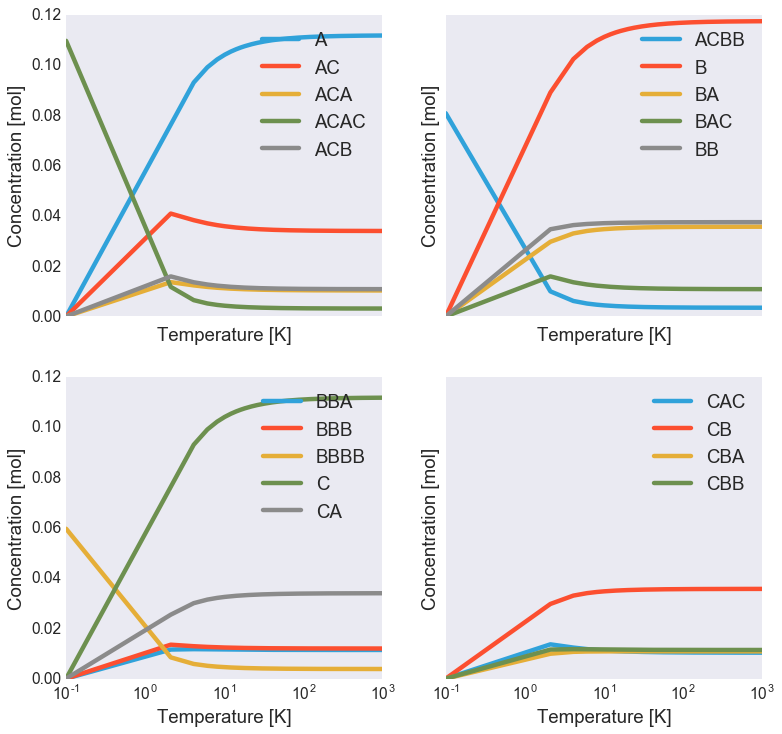

In [26]:
# plot the results
fig, axs = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
axs_flat = axs.flatten()
ax_counter = 0
for i, compound in enumerate(compounds):
    if not i%5:
        ax = axs_flat[ax_counter]
        ax_counter += 1
    ax.semilogx(T_array, xstar_ifo_T[:, i], label=compound)
    ax.set_ylabel('Concentration [mol]')
    ax.set_xlabel('Temperature [K]')
    ax.legend(loc='upper right')

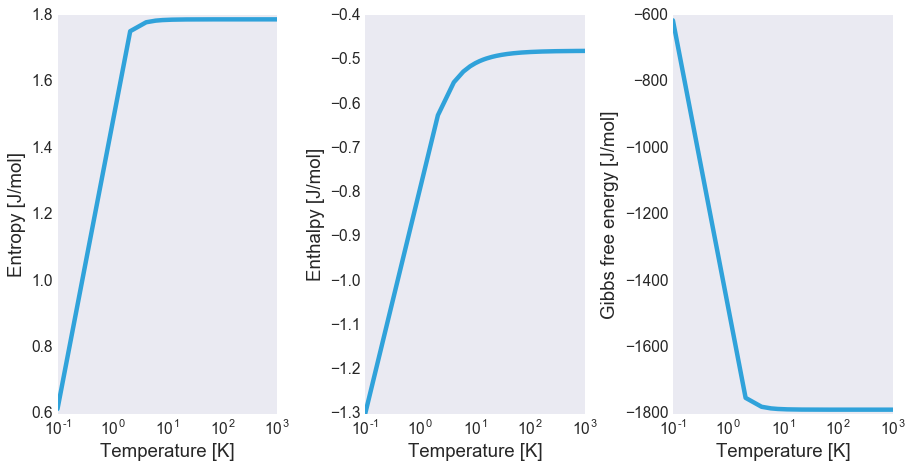

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
entropy_ifo_T = np.apply_along_axis(entropy, 1, xstar_ifo_T)
enthalpy_ifo_T = np.apply_along_axis(enthalpy, 1, xstar_ifo_T)
gibbs_ifo_T = enthalpy_ifo_T - T*entropy_ifo_T
axs[0].semilogx(T_array, entropy_ifo_T)
axs[0].set_ylabel('Entropy [J/mol]')
axs[0].set_xlabel('Temperature [K]')
axs[1].semilogx(T_array, enthalpy_ifo_T)
axs[1].set_ylabel('Enthalpy [J/mol]')
axs[1].set_xlabel('Temperature [K]')
axs[2].semilogx(T_array, gibbs_ifo_T)
axs[2].set_ylabel('Gibbs free energy [J/mol]')
axs[2].set_xlabel('Temperature [K]')

**Describe the obtained plots and give a physicochemical interpretation**

Rather than interpreting the plots of Entropy and Enthalpy separately, the Gibbs free energy is plotted in the fourth column. The evolution of the equilibrium concentrations follow the trends in the Gibbs free energy perfectly. Taking the concentration of *AC* (row 2) as an example. The concentration increases with the temperature. At a certain temperature, the Gibbs free energy reaches a minimum and starts to increase again. At that point, AC becomes less favorable to produce and the concentration starts decreasing, subsequently other more favorable components will achieve higher equilibrium concentrations.    

**Assignment 7**

In [28]:
from scipy.interpolate import griddata

def calcfigwidth(height, fcolorbar=0.05):
    ''' calculates the width of the figure, based on the height, and the size fraction
    of the subfigure (colorbar) compared to the contourplot.
    The width is calculated as such that the resulting plot is square (i.e. the x and y
    axis are equal in length)
    fcolorbar is the size fraction of the colorbar compared to the figure
    '''
    wspace =  plt.rcParams['figure.subplot.wspace']
    left =  plt.rcParams['figure.subplot.left']
    right =  plt.rcParams['figure.subplot.right']
    top =  plt.rcParams['figure.subplot.top']
    bottom =  plt.rcParams['figure.subplot.bottom']
    figwidth = (top - bottom)*height/(((1-left-(1-right))/(1+fcolorbar+wspace*(1-fcolorbar)/2)))
    return figwidth

def plotcontour(ax, x, y, z,):
    xi = yi = np.linspace(0, 1, 50)
    # grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    # contour the gridded data, plotting dots at the randomly spaced data points.
    cs = ax.contourf(xi, yi, zi, cmap='viridis')
    return ax, cs

def plotscatter(ax, x, y, z):
    sc = ax.scatter(x=x, y=y, c=z, s=250, marker='.', cmap='viridis')
    return ax, sc

def plotmassbalance_errors(ax, x, y):
    idx = massbalance > treshold
    ax.plot(x[idx], y[idx], 'o', color='red')
    return ax

def applyplotoptions(ax, cax, mappable, cbar_label, param_x, param_y):
    cbar = plt.colorbar(mappable=mappable, cax=cax)
    cbar.set_label(cbar_label, rotation=90, labelpad=0, y=0.5)
    ax.set_xlabel(param_x)
    ax.set_ylabel(param_y)
    ax.set_ylim([0., 1.])
    ax.set_xlim([0., 1.])
    return ax, cax, cbar

def plot_all(z, z_label, plottype='contour', plotmassbalanceerrors=False):
    if (z_label is 'entropy') or (z_label is 'CBA'):
        idx = np.where(np.isclose(z - z.max(), 0.))[0]
    else:
        idx = np.where(np.isclose(z - z.min(), 0.))[0]
    for i, j in itertools.combinations(range(3), 2):
        x = c_all[:, i]
        x_label = monomers[i]
        y = c_all[:, j]
        y_label = monomers[j]
    
        figheight = 5
        figwidth = calcfigwidth(figheight)
        fcolorbar = 0.05
        fig, (ax, cax) = plt.subplots(ncols=2, figsize=(figwidth, figheight),
                                      gridspec_kw={"width_ratios":[1, fcolorbar]})
        if plottype == 'contour':
            ax, mappable = plotcontour(ax, x, y, z)
        else:
            ax, mappable = plotscatter(ax, x, y, z)
        if plotmassbalanceerrors:
            ax = plotmassbalance_errors(ax, x, y)
        ax.plot(x[idx], y[idx], '*', color='blue', markersize=10)
        ax, cax, cbar = applyplotoptions(ax, cax, mappable, z_label, x_label, y_label)

In [29]:
# Use grid search to find initial mixtures of A, B and C that give rise to mixtures
# with the highest entropy, lowest entropy and highest concentration of CBA at 100K.

In [30]:
import itertools

T = 100
c_min = 0.05
c_tot = 1
delta_c = 0.05

c_values = np.arange(c_min, c_tot+delta_c, delta_c)
combos = itertools.combinations_with_replacement(c_values, 3)
filtered_combos = np.array(list(filter(lambda tup: np.isclose(np.sum(tup), 1.), combos)))
# swap columns
idx_colswaps = list(itertools.permutations([0, 1, 2]))
# stack the swapped columns
c_all = np.vstack((filtered_combos[:, idx] for idx in idx_colswaps))
# remove duplicates, just to make sure that scenarios are unique
c_all = np.unique(c_all, axis=0)
# allocate space for concentrations
x_star_all = np.empty((c_all.shape[0], 19))
massbalance = np.empty((c_all.shape[0],))

In [31]:
for i in range(c_all.shape[0]):
    c = np.atleast_2d(c_all[i, :]).T
    x_star = newton_oligomerization(10*x0, S, c, T, stepsize=1e-1)
    # check if solution satisfies mass balance
    massbalance[i] = np.abs(S @ x_star - c).max()
    #assert np.alltrue(np.abs(S @ x_star_all[i, :] - c) < treshold)
    x_star_all[i, :] = x_star.flatten()

entropy_all = np.apply_along_axis(entropy, 1, x_star_all)
enthalpy_all = np.apply_along_axis(enthalpy, 1, x_star_all)

idx = compounds.index('CBA')
CBA_all = x_star_all[:, idx]

**Find inital mixture which will lead to the highest entropy.**

/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


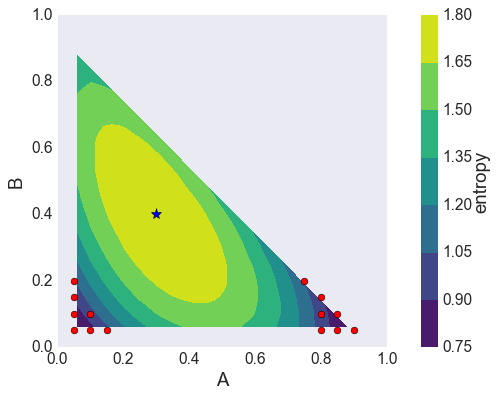

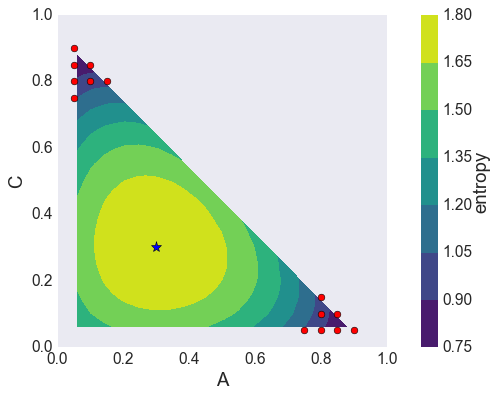

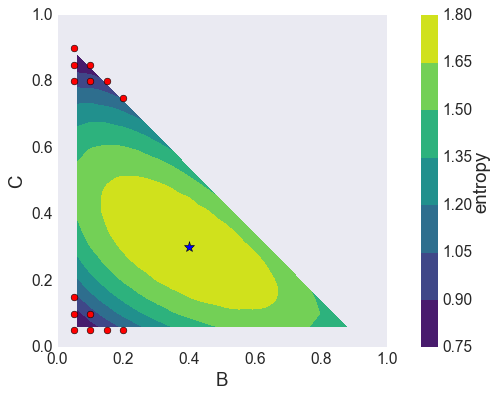

In [32]:
plot_all(entropy_all, 'entropy', plotmassbalanceerrors=True)

In [33]:
idx = np.where(np.isclose(entropy_all - entropy_all.max(), 0.))[0]
print("Initial mixture with highest entropy: ", c_all[idx, :])
print("Entropy value: ", entropy_all.max())

Initial mixture with highest entropy:  [[0.3 0.4 0.3]]
Entropy value:  1.7875758517543645


**Find inital mixture which will lead to the lowest enthalpy.**

/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


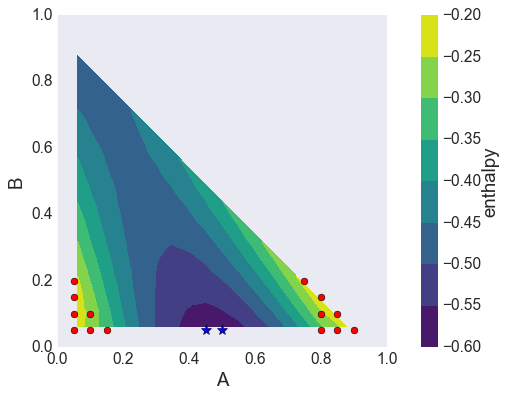

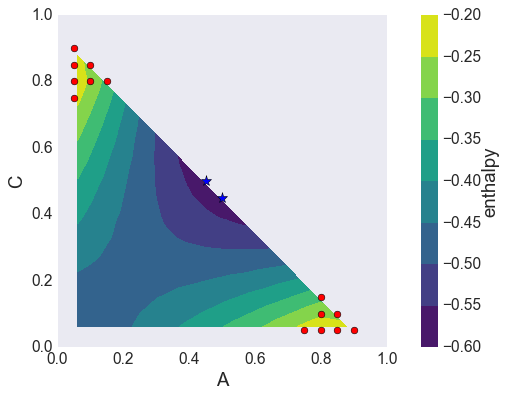

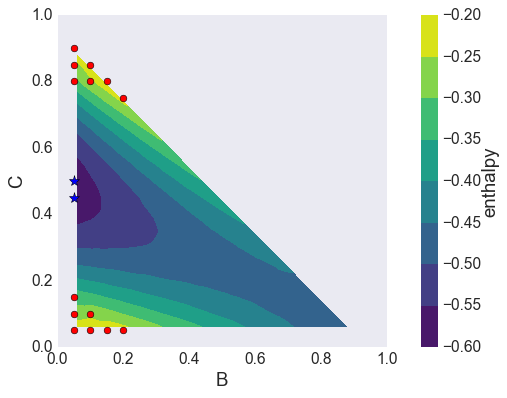

In [34]:
plot_all(enthalpy_all, 'enthalpy', plottype='contour', plotmassbalanceerrors=True)

In [35]:
idx = np.where(np.isclose(enthalpy_all - enthalpy_all.min(), 0.))[0]
print("Initial mixture with lowest enthalpy: ", [c_all[i, :] for i in idx])
print("Enthalpy value: ", enthalpy_all.min())

Initial mixture with lowest enthalpy:  [array([0.45, 0.05, 0.5 ]), array([0.5 , 0.05, 0.45])]
Enthalpy value:  -0.5831409782959915


**Find inital mixture which will lead to the highest concentration CBA.**

/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jos/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


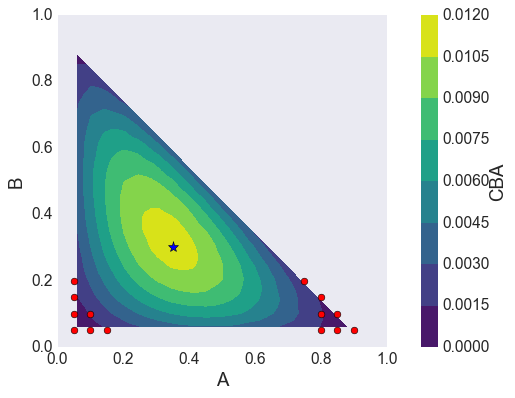

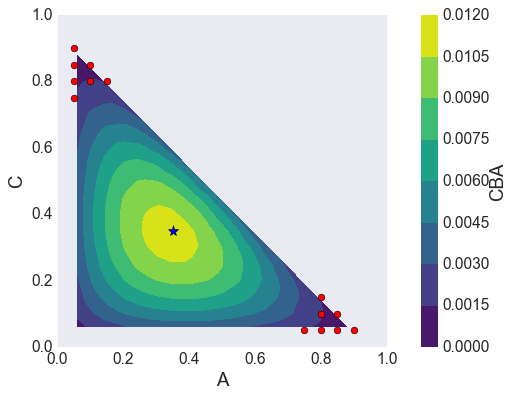

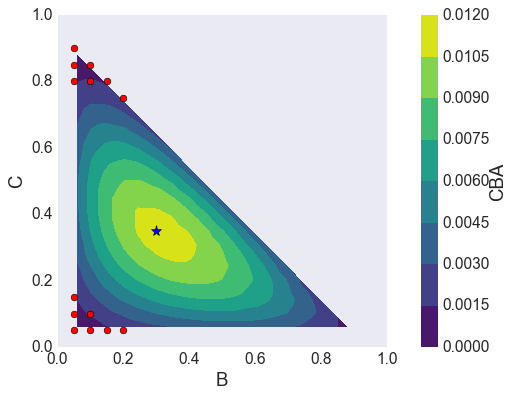

In [36]:
plot_all(CBA_all, 'CBA', plotmassbalanceerrors=True)

In [37]:
idx = np.where(np.isclose(CBA_all - CBA_all.max(), 0.))[0]
print("Initial mixture with highest end concentration of CBA: ", c_all[idx, :])
print("CBA concentration: ", CBA_all.max())

Initial mixture with highest end concentration of CBA:  [[0.35 0.3  0.35]]
CBA concentration:  0.011196982087538398


## References

Boyd, S. and Vandenberghe, L., '*[Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)*'. Cambridge University Press (2004)